# AIT Deep Learning Pedestrian Detection Project

Note: We used GitHub Copilot to generate some of the code, such as displaying images using matplotlib.

### 1-1: Load Images and annotations.

In [12]:
!pip freeze

absl-py==2.1.0
alabaster @ file:///home/ktietz/src/ci/alabaster_1611921544520/work
anaconda-client==1.11.0
anaconda-navigator==2.3.1
anaconda-project @ file:///C:/Windows/TEMP/abs_91fu4tfkih/croots/recipe/anaconda-project_1660339890874/work
anyio @ file:///C:/ci/anyio_1644481921011/work/dist
appdirs==1.4.4
argon2-cffi @ file:///opt/conda/conda-bld/argon2-cffi_1645000214183/work
argon2-cffi-bindings @ file:///C:/ci/argon2-cffi-bindings_1644551690056/work
arrow @ file:///opt/conda/conda-bld/arrow_1649166651673/work
astroid @ file:///C:/Windows/TEMP/abs_b0dtxgpicv/croots/recipe/astroid_1659023126745/work
astropy @ file:///C:/ci/astropy_1657719656942/work
astunparse==1.6.3
atomicwrites==1.4.0
attrs @ file:///opt/conda/conda-bld/attrs_1642510447205/work
Automat @ file:///tmp/build/80754af9/automat_1600298431173/work
autopep8 @ file:///opt/conda/conda-bld/autopep8_1650463822033/work
Babel @ file:///tmp/build/80754af9/babel_1620871417480/work
backcall @ file:///home/ktietz/src/ci/backcall_161

In [16]:
!pip show pycocotools

Name: pycocotools
Version: 2.0
Summary: 
Home-page: 
Author: 
Author-email: 
License: 
Location: c:\users\tsugu\anaconda3\lib\site-packages
Requires: 
Required-by: 


In [1]:
%reset -f
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pycocotools.coco import COCO

import numpy as np
import pylab
import random
import pickle as pk
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import backend

pylab.rcParams['figure.figsize'] = (10.0, 8.0)

c:\Users\tsugu\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# We are using their validation images for testing, as they don't provide a test annotation.
train_anno = 'annotations/dhd_pedestrian_traffic_train.json'
test_anno = 'annotations/dhd_pedestrian_traffic_val.json' 

train_image_dir = "images/train/"
test_image_dir = "images/val/"

coco_train = COCO(train_anno)
coco_test = COCO(test_anno)

loading annotations into memory...
Done (t=0.53s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [3]:
def get_coco_and_dir(img_type):
    '''
    Return the corresponding coco, and image dir based on image type (train, test)
    '''
    if img_type in ("train", "valid"):
        return coco_train, train_image_dir
    elif img_type == "test":
        return coco_test, test_image_dir
    else:
        raise ValueError("Unknown image type")

### Load an example image and annotation.

In [4]:
len(coco_train.getImgIds())

13858

In [5]:
# Displaying image with annotation
def show_image(img_type, image_id, image_path, show_anns=True):
    coco, _ = get_coco_and_dir(img_type)
    
    plt.axis('off')
    image = mpimg.imread(image_path)
    plt.imshow(image)
    if show_anns:
        annIds = coco.getAnnIds(imgIds=image_id)
        anns = coco.loadAnns(annIds)
        print("There are", len(annIds), "pedestrians")
        coco.showAnns(anns)

There are 6 pedestrians


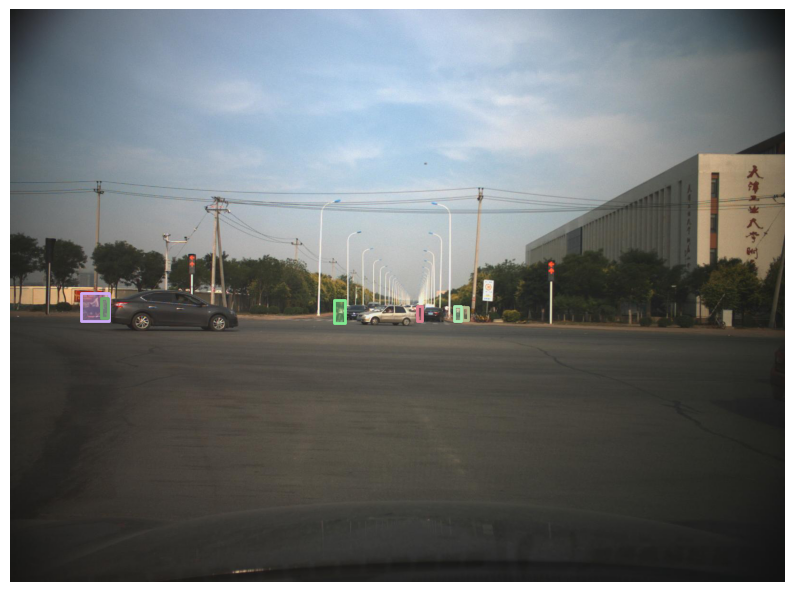

In [6]:
image_id = coco_train.getImgIds()[9]
image_path = train_image_dir + coco_train.loadImgs(image_id)[0]['file_name']
show_image("train", image_id, image_path)

### 1-2 Process Training, Validation, and Test dataset

In [7]:
train_rate = 0.8

train_valid_imgIds = coco_train.getImgIds()
random.shuffle(train_valid_imgIds)

train_imgIds = train_valid_imgIds[:int(train_rate * len(train_valid_imgIds))]
valid_imgIds = train_valid_imgIds[int(train_rate * len(train_valid_imgIds)):]
test_imgIds = coco_test.getImgIds()

print("Number of pictures in the train data     :", len(train_imgIds))
print("Number of pictures in the validation data:", len(valid_imgIds))
print("Number of pictures in the test data      :", len(test_imgIds))

Number of pictures in the train data     : 11086
Number of pictures in the validation data: 2772
Number of pictures in the test data      : 2136


However, we do not intend to use all of the available data. Thus, we will took a sample from training, valid, and test data.

In the end, we aim for 5000 training, 500 valid, and 1000 test data.

In [8]:
sample_train_imgIds = random.sample(train_imgIds, k = 5000)
sample_valid_imgIds = random.sample(valid_imgIds, k = 500)
sample_test_imgIds = random.sample(test_imgIds, k = 1000)

## R-CNN   

In [14]:
def intersection_over_union(box_1, box_2):
    x1 = max(box_1[0], box_2[0])
    x2 = min(box_1[0] + box_1[1], box_2[0] + box_2[1])
    y1 = max(box_1[2], box_2[2])
    y2 = min(box_1[2] + box_1[3], box_2[2] + box_2[3])
    intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    box_1_area = (box_1[1] - box_1[0] + 1) * (box_1[3] - box_1[2] + 1)
    box_2_area = (box_2[1] - box_2[0] + 1) * (box_2[3] - box_2[2] + 1)
    union = box_1_area + box_2_area - intersection

    return intersection / union

In [37]:
import cv2
from tensorflow.keras.applications.vgg16 import preprocess_input

def load_image(image_path):
    image = cv2.imread(image_path)
    return image

def generate_regions(image):
    # Perform selective search to generate regions
    selective_search = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    selective_search.setBaseImage(image)
    selective_search.switchToSelectiveSearchFast()
    proposedRects = selective_search.process()
    return proposedRects

def contains_pedestrian(region, annotations):
    # Check if the region contains a pedestrian using intersection over union
    for annotation in annotations:
        iou = intersection_over_union(region, annotation["bbox"])
        if iou > 0.7:
            return True
    return False

def load_segment_images(img_type, imgIds):
    MAX_POSITIVE = 20
    MAX_NEGATIVE = 10
    MAX_INFER = 2000
    SMALLEST_PIXEL = 5

    coco, image_dir = get_coco_and_dir(img_type)
    
    pedestrian_images = []
    no_pedestrian_images = []
    total_images = len(imgIds)
    progress_interval = total_images // 10

    for i, imgId in enumerate(imgIds):
        image_path = image_dir + coco.loadImgs(imgId)[0]['file_name']
        image = load_image(image_path)
        regions = generate_regions(image)
        annotations = coco.loadAnns(coco.getAnnIds(imgIds=imgId))
        # print(regions[0], annotations[0])

        pedestrian_count = 0
        no_pedestrian_count = 0

        for region in regions[:MAX_INFER]:
            if region[2] < SMALLEST_PIXEL or region[3] < SMALLEST_PIXEL:
                continue

            if contains_pedestrian(region, annotations) and pedestrian_count < MAX_POSITIVE:
                pedestrian_images.append(process_image(image[region[1]:region[1]+region[3], region[0]:region[0]+region[2]]))
                pedestrian_count += 1
            elif no_pedestrian_count < MAX_NEGATIVE:
                no_pedestrian_images.append(process_image(image[region[1]:region[1]+region[3], region[0]:region[0]+region[2]]))
                no_pedestrian_count += 1
            elif pedestrian_count >= MAX_POSITIVE and no_pedestrian_count >= MAX_NEGATIVE:
                break
        
        if total_images >= 12:
            if (i + 1) % progress_interval == 0:
                progress = round((i + 1) / total_images * 10)
                print(f"[{'*' * progress}{'.' * (10-progress)}]")
        else:
            print("Image ", i, " done. ")

    return np.array(pedestrian_images), np.array(no_pedestrian_images)

def process_image(image):
    # Resize image to 224x224
    image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)
    # Convert the image to an array
    image = image_utils.img_to_array(image, dtype="float32")
    # Preprocess the image
    image = preprocess_input(image)
    return image

def load_and_process_images(img_type, imgIds):
    pedestrian_images, no_pedestrian_images = load_segment_images(img_type, imgIds)
    X = np.concatenate([pedestrian_images, no_pedestrian_images])
    Y = np.concatenate([np.ones(len(pedestrian_images)), np.zeros(len(no_pedestrian_images))])  

    # Shuffle X and Y together
    combined = list(zip(X, Y))
    np.random.shuffle(combined)
    X_shuffled, Y_shuffled = zip(*combined)

    # Convert back to numpy arrays
    X_shuffled = np.array(X_shuffled)
    Y_shuffled = np.array(Y_shuffled)

    return X_shuffled, Y_shuffled

In [38]:
TRAIN_MAX = 3
VALID_MAX = 1
TEST_MAX = 2

X_train, Y_train = load_and_process_images("train", sample_train_imgIds[:TRAIN_MAX])
X_valid, Y_valid = load_and_process_images("valid", sample_valid_imgIds[:VALID_MAX])
X_test, Y_test = load_and_process_images("test", sample_test_imgIds[:TEST_MAX])


Image  0  done. 
Image  1  done. 
Image  2  done. 


In [39]:
X_train.shape, Y_train.shape

((90, 224, 224, 3), (90,))

In [40]:
Y_train

array([0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1.,
       0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
       0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1.])

array([[[[-64.939   , -79.779   , -85.68    ],
         [-64.939   , -79.779   , -85.68    ],
         [-64.939   , -79.779   , -85.68    ],
         ...,
         [-47.939003, -54.779   , -63.68    ],
         [-47.939003, -54.779   , -63.68    ],
         [-47.939003, -54.779   , -63.68    ]],

        [[-64.939   , -79.779   , -85.68    ],
         [-64.939   , -79.779   , -85.68    ],
         [-64.939   , -79.779   , -85.68    ],
         ...,
         [-47.939003, -54.779   , -63.68    ],
         [-47.939003, -54.779   , -63.68    ],
         [-47.939003, -54.779   , -63.68    ]],

        [[-64.939   , -79.779   , -85.68    ],
         [-64.939   , -79.779   , -85.68    ],
         [-64.939   , -79.779   , -85.68    ],
         ...,
         [-47.939003, -54.779   , -63.68    ],
         [-47.939003, -54.779   , -63.68    ],
         [-47.939003, -54.779   , -63.68    ]],

        ...,

        [[-22.939003, -35.779   , -42.68    ],
         [-22.939003, -35.779   , -42.68    ]